# Visualising the top baby names in the US and predicting genders

**Source:** \
State-wise top baby names in the US from the Social Security administration website. The dataset is hosted by the Social Security Administration (SSA) and is intended for public access and use. The dataset was downloaded from https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-national-level-data as a 21 MB zip file.

**About Dataaset:** \
The zip file contains individual state-wise text files of top baby names in that particular state from 1910 to 2018. Each text file contains 5 features - state postal code, gender, year of birth, first name and number of samples of the name. The data (as claimed by the website) was sampled by the SSA from 100% of all social security card applications. 

**Motivation:** \
To visually explore this dataset and build a simple model to predict and individual's gender based on his/her name.

**Libraries:** 
- numpy and pandas for data structure manipulation
- matplotlib and seaborn for data visualisation
- sklearn for building a logistic regressor and support vector classifier

***
## Importing Libraries
***

Libraries relevent for data manipulation, data visualisation and model building are imported

In [122]:
# Libraries for data manipulation
import numpy as np
import pandas as pd
from pathlib import Path

# Libraries for data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from wordcloud import WordCloud, get_single_color_func #For creating word cloud
import geopandas as gpd #For creating choropleth
import imageio #For creating the gif of choropleths

%matplotlib inline
plt.style.use('seaborn-colorblind')

# Libraries for building classifiers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
import warnings
warnings.filterwarnings('ignore')

***
## Data Source
***

Writing a function to automate the reading of the text file in the local directory and storing the values

In [3]:
# List of states and state postal codes
states = pd.read_csv('states.csv', index_col=['postal_code'])

# Dictionary of state codes and state names
code_dict = dict(states.state)

# Generating string of file names for reading into dataframe
file_name = [(text+'.TXT') for text in states.index]

In [4]:
def file_reader(file_name):
    code = []
    year = []
    name = []
    gender = []
    number = []
    
    # with statement automatically opens and closes the file object once it is read
    with open(file_name, 'r') as file:
        line = file.readline().rstrip()
        while line:
            line_split = line.split(',')
            code.append(line_split[0])    #State Code
            gender.append(line_split[1])  #Gender
            year.append(line_split[2])    #Year of birth
            name.append(line_split[3])    #First Name
            number.append(line_split[4])  #Number of samples

            line = file.readline().rstrip()
    
    # Imputing the values into a dataframe for easy manipulation
    result = pd.DataFrame({'state_code':code,
                           'yob':year,
                           'name':name,
                           'gender':gender,
                           'number':number})
    return result

In [5]:
result = pd.DataFrame([], columns=['state_code',
                                   'yob',
                                   'name',
                                   'gender',
                                   'number'])
for file in file_name:
    result = pd.concat([result, file_reader(file)],axis=0)

***
## Data Preprocessing
***

The dataset is checked for some basic information about the data and to see if any cleaning/re-formatting is required

**1. Basic information on the data**

In [6]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6028151 entries, 0 to 28019
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   state_code  object
 1   yob         object
 2   name        object
 3   gender      object
 4   number      object
dtypes: object(5)
memory usage: 275.9+ MB


<font color=red>**Observation:**</font>
- The dataset is huge and nearly takes up 280 MB of memory.
- This because the data spans names from 1910 till 2018.
- The yob and number are object types. They have to be reformatted into int64.
- The state names in lowercase are added as it would be helpful in later analysis

**2. Reformatting datatypes of features**

In [7]:
result['yob'] = result['yob'].apply(lambda x: int(x))

In [8]:
result['number'] = result['number'].apply(lambda x: int(x))

**3. Adding the state names in lower case as additional feature and dropping state_code**

In [9]:
for key, value in code_dict.items():
    result.loc[result.state_code==key, 'state'] = value.lower()

In [10]:
result = result.drop(columns=['state_code'])

**4. Converting names to lowercase**

In [11]:
result['name'] = result['name'].apply(lambda x: x.lower())

**5. Adding a chk feature, for its helpfullness**

In [12]:
result['chk'] = 1

**Preprocessed dataset**

In [13]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6028151 entries, 0 to 28019
Data columns (total 6 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   yob     int64 
 1   name    object
 2   gender  object
 3   number  int64 
 4   state   object
 5   chk     int64 
dtypes: int64(3), object(3)
memory usage: 321.9+ MB


In [14]:
result.head()

,yob,name,gender,number,state,chk
0,1910,mary,F,875,alabama,1
1,1910,annie,F,482,alabama,1
2,1910,willie,F,257,alabama,1
3,1910,mattie,F,232,alabama,1
4,1910,ruby,F,204,alabama,1


In [15]:
result.tail()

,yob,name,gender,number,state,chk
28015,2018,peyton,M,5,wyoming,1
28016,2018,richard,M,5,wyoming,1
28017,2018,titus,M,5,wyoming,1
28018,2018,tristan,M,5,wyoming,1
28019,2018,zander,M,5,wyoming,1


**Saving the result in a dataframe df**

In [16]:
df = result

***
## Exploratory Data Analysis
***

Before we build a model, we explore the dataset to gain some insights on the trends

**1. Top 100 most common names in the last 100 years**

<font color =blue>Helper function to generate wordcloud</font>

In [17]:
class single_color_func(object):
    """Create a color function object that assigns certain colors
       to names that fall under each gender category 
       based on the color to words mapping
    
    """

    def __init__(self, color_to_words):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word)

def names_wordcloud(data, gender, max_words, sort, color, background, title = None):
    
    """Word cloud genertor for the string of names
    as input"""
    
    name_freq = dict(data.loc[data.gender==gender].name.value_counts().sort_values(ascending=sort).tail(100))
    color_to_words = {color: pd.unique(data.loc[data.gender==gender].name)}
    get_color_func = single_color_func(color_to_words)
    
    wordcloud = WordCloud(
        background_color = background,
        max_font_size = 40,
        max_words = max_words, 
        scale = 3,
        random_state = None,
        contour_width=2
    ).generate_from_frequencies(name_freq)

    fig = plt.figure(1, figsize = (15, 6))
    plt.axis('off')
    
    if title: 
        fig.suptitle(title, fontsize = 14)
        
    wordcloud.recolor(color_func=get_color_func)
    plt.imshow(wordcloud)
    
    plt.show()

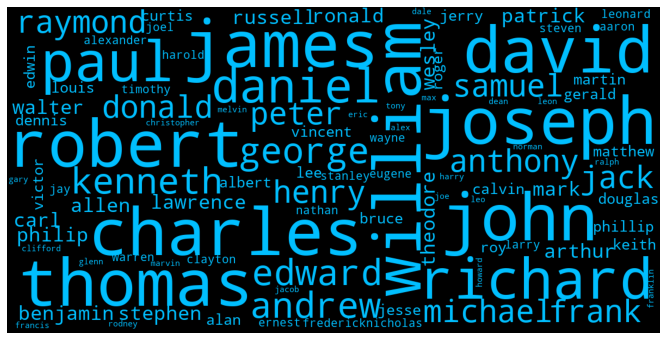

In [18]:
names_wordcloud(df, 'M', 100, True, 'deepskyblue', 'black', title = None)

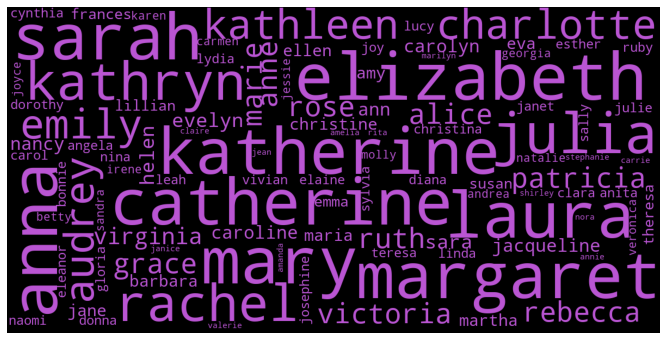

In [19]:
names_wordcloud(df, 'F', 100, True, 'mediumorchid', 'black', title = None)

**2. Top 100 most unusual names in the last 100 years**

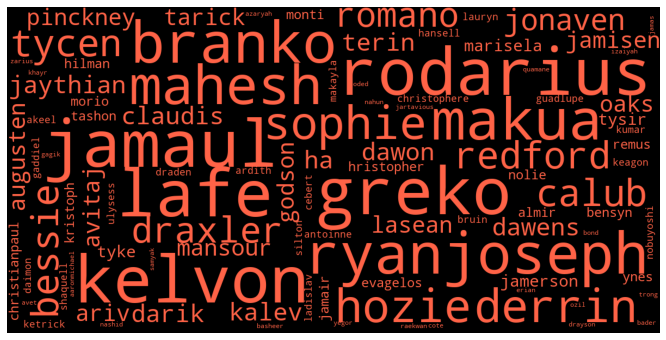

In [20]:
names_wordcloud(df, 'M', 100, False, 'tomato', 'black', title = None)

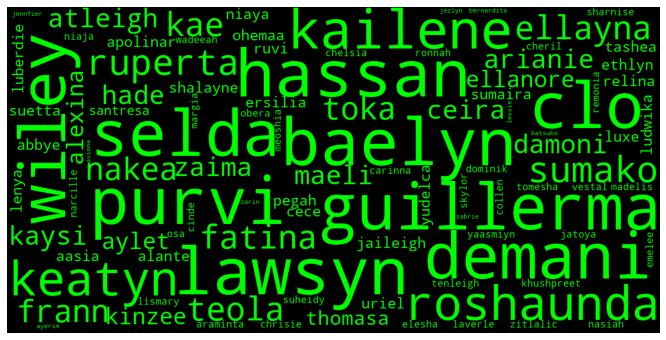

In [21]:
names_wordcloud(df, 'F', 100, False, 'lime', 'black', title = None)

**2. Top names of 2018**

In [22]:
male_names_years = pd.pivot_table(df.loc[df.gender=='M'], 
                             values='number', 
                             index='name', 
                             columns='yob', 
                             aggfunc=np.mean).round()

female_names_years = pd.pivot_table(df.loc[df.gender=='F'], 
                             values='number', 
                             index='name', 
                             columns='yob', 
                             aggfunc=np.mean).round()

<font color=blue>Top 5 male names of 2018</font>

In [23]:
print(male_names_years.loc[:,2018].sort_values(ascending=False).head(5))

name
liam       389.0
noah       358.0
william    285.0
james      265.0
oliver     263.0
Name: 2018, dtype: float64


<font color=blue>Top 5 female names of 2018</font>

In [24]:
print(female_names_years.loc[:,2018].sort_values(ascending=False).head(5))

name
emma        366.0
olivia      351.0
ava         293.0
isabella    284.0
sophia      273.0
Name: 2018, dtype: float64


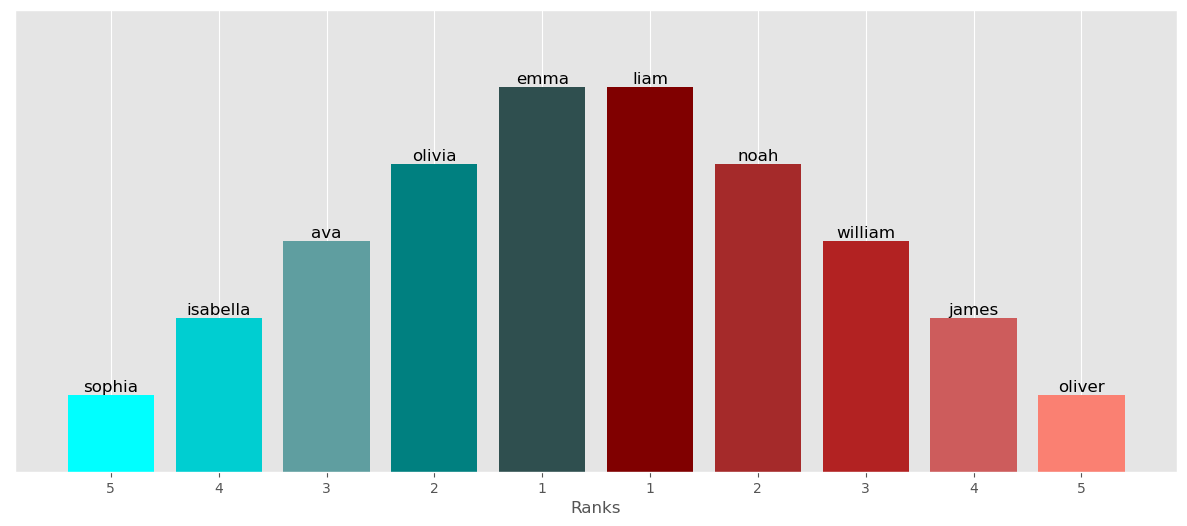

In [70]:
plt.style.use('ggplot')

names = ['sophia', 'isabella', 'ava', 'olivia','emma', 'liam','noah','william', 'james','oliver']
ticks = np.arange(0, len(names))
labels = [5,4,3,2,1,1,2,3,4,5]
values = [1,2,3,4,5,5,4,3,2,1]
colors = ['cyan','darkturquoise','cadetblue','teal','darkslategrey',
          'maroon','brown','firebrick','indianred','salmon']

fig = plt.subplots(figsize=[15,6])
bar = plt.bar(ticks, values, color=colors)
plt.ylim(0,6)
plt.yticks([])
plt.xticks(ticks, labels)
plt.xlabel('Ranks')

for rect, name in zip(bar, names):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, s=name, 
             ha='center', va='bottom', fontsize=12)

**3. History of top 5 popular names of 2018**

<font color=blue>Helper function to assign ranks to names</font>

In [71]:
def year_rank_lister(df):
    
    ranklist = pd.DataFrame([], columns=['name','rank', 'year'])
    for y in np.arange(1910,2019):
        temp = pd.DataFrame(df[y].sort_values(ascending=False).dropna().index)
        temp['rank'] = np.arange(1,temp.shape[0]+1)
        temp['year'] = y
        ranklist = pd.concat([ranklist, temp],axis=0)
        
    return ranklist

In [72]:
female_year_ranks = year_rank_lister(female_names_years)
male_year_ranks = year_rank_lister(male_names_years)

top_names_2018_male = male_names_years.loc[:,2018].sort_values(ascending=False).head(5).index
top_names_2018_female = female_names_years.loc[:,2018].sort_values(ascending=False).head(5).index

In [73]:
def rank_plotter(rank_list, name_list):
    
    plt.style.use('ggplot')
    
    fig,ax = plt.subplots(figsize=[15,6])
    
    for name in name_list:
        plotdf = rank_list.loc[rank_list.name==name]
        ax.plot(plotdf['year'], plotdf['rank'], marker='.', ms=8,  label=name)
        ax.legend()

        ax.set_xlim(1900, 2019)
        ax.set_ylim(3000, 1)
        ax.set_yscale('log')
        ax.set_ylabel('Rank')

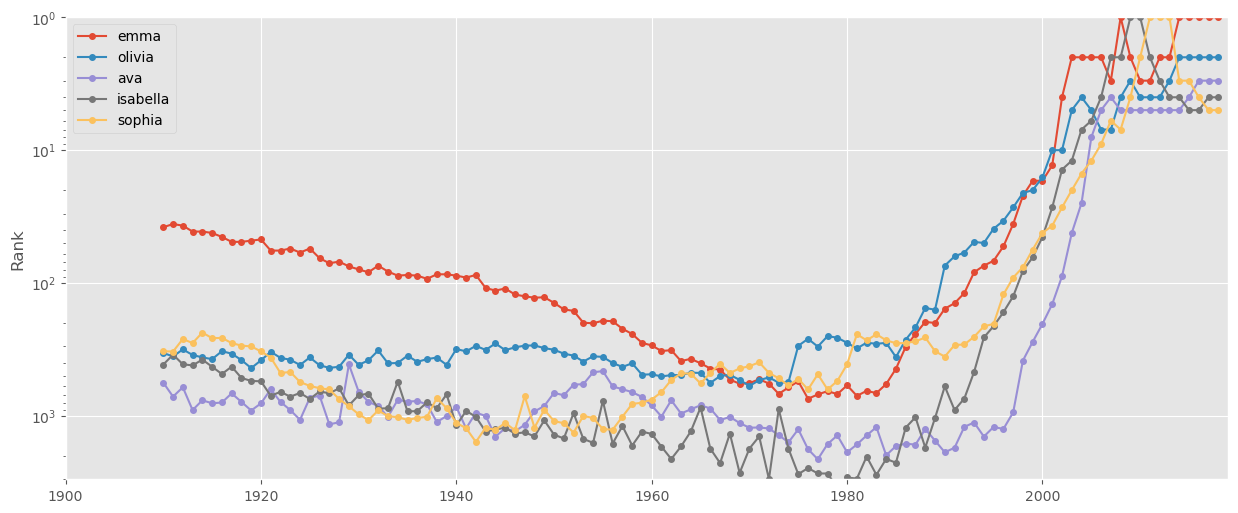

In [74]:
rank_plotter(female_year_ranks, top_names_2018_female)

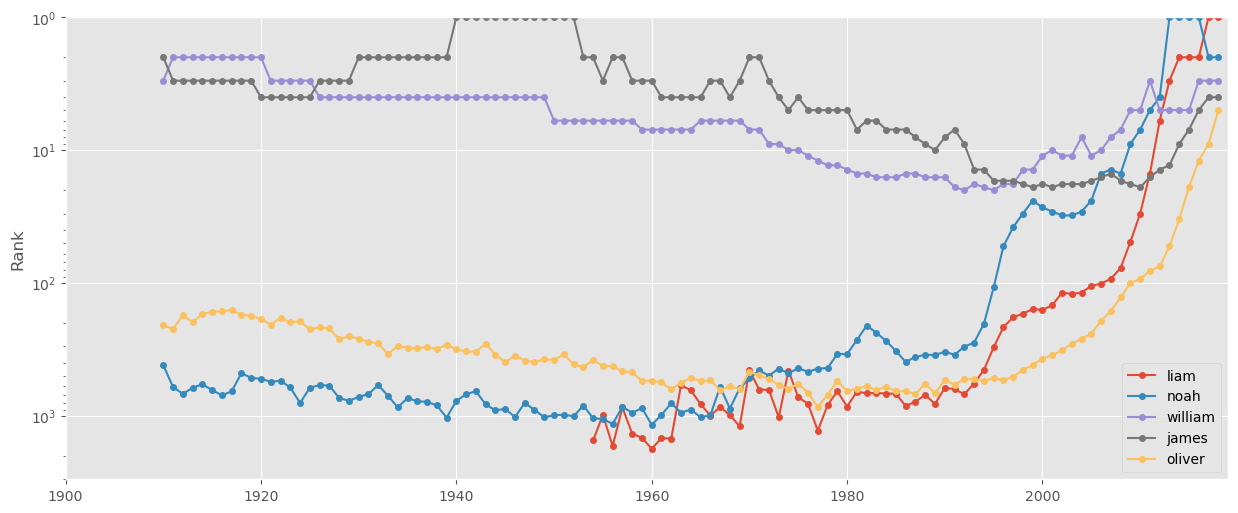

In [75]:
rank_plotter(male_year_ranks, top_names_2018_male)

**4. Choropleths of 5 most popular names of 2018**

<font color=blue>Helper function to rank the names in each state</font>

In [76]:
def state_rank_lister(df, sort):
    result = pd.DataFrame([], columns=['state', 'name', 'rank'])
    for s in df.columns:
        names = df[s].dropna().sort_values(ascending=False).index
        ranks = np.arange(1,len(names)+1)
        output = pd.DataFrame({'state': len(names)*[s], 'name':names, 'rank':ranks})
        result = pd.concat([result, output], axis=0)
    return result

In [77]:
male_names_states = pd.pivot_table(df.loc[(df.yob==2018)&(df.gender=='M')], 
                                   values='number', 
                                   index='name', 
                                   columns='state', 
                                   aggfunc=np.mean)

female_names_states = pd.pivot_table(df.loc[(df.yob==2018)&(df.gender=='F')], 
                                   values='number', 
                                   index='name', 
                                   columns='state', 
                                   aggfunc=np.mean)

male_state_ranker = state_rank_lister(male_names_states, False)
female_state_ranker = state_rank_lister(female_names_states, False)

Loading US state boundaries shape file

In [78]:
us_map = gpd.read_file('states.shp')
us_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATE_NAME  51 non-null     object  
 1   DRAWSEQ     51 non-null     int64   
 2   STATE_FIPS  51 non-null     object  
 3   SUB_REGION  51 non-null     object  
 4   STATE_ABBR  51 non-null     object  
 5   geometry    51 non-null     geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 2.5+ KB


In [79]:
mapdf = us_map[['STATE_NAME','geometry']]
mapdf['STATE_NAME'] = mapdf['STATE_NAME'].apply(lambda x: x.lower())
mapdf['chk'] = np.ones(mapdf.shape[0])

<font color=blue>Helper function to plot the ranks of names across each state in the US</font>

In [80]:
def rank_choropleth(top_names, name, colors, title, folder):    
    # Selecting the states which contain the name of choice
    rankdf = top_names.loc[top_names.name==name][['state','rank']]
    
    #Populating the mapdf with the rank corresponding to the state
    for i in range(rankdf.shape[0]):
        s = rankdf.iloc[i,0]
        r = rankdf.iloc[i,1]
        mapdf.loc[mapdf['STATE_NAME']==s, 'rank_value'] = r

    ## Plotting chloropleth
    fig,ax = plt.subplots(figsize=[15,15])
    
    variable = 'rank_value'
    vmin, vmax = mapdf.rank_value.min(), mapdf.rank_value.max()

    # Create colorbar legend
    cbar_ax = inset_axes(ax,
                        width="5%",  # width = 50% of parent_bbox width
                        height="200%",  # height : 5%
                        bbox_to_anchor=(0.06,0.5,1,0.5),
                        bbox_transform=ax.transAxes,
                        )
    cb = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # Plot the name rank choropleth
    ax.grid(b=None, color='grey', linestyle=':', linewidth=0.5)

    base_map = mapdf.plot(column='chk',
                          color='white',
                          linewidth=0.5, 
                          edgecolor='k', 
                          ax=ax, 
                          alpha=0.5)

    rank_map = mapdf.plot(column=variable, 
                          cmap=colors, 
                          linewidth=0.5, 
                          edgecolor='k', 
                          ax=ax)

    # Add the colorbar to the figure
    fig.colorbar(cb, 
                 cax=cbar_ax, 
                 label='Rank', 
                 orientation='vertical',
                 ticks=np.arange(vmin, vmax+1, 10))
    
    # Set the axes properties
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitutde', fontsize=12)
    ax.tick_params(labelsize=12)
    
    file_path = folder+'/'+name
    plt.savefig(file_path, bbox_inches='tight')
    plt.close(fig)

**Creating the choropleths of all male names that are ranked between 1 and 5**

In [81]:
data = male_state_ranker
names = pd.unique(data.loc[data['rank']<=5].name)
for name in names:
    title = 'Popularity of the name ' + name + ' across the US in 2018'
    rank_choropleth(data, name, 'YlGnBu_r', title, 'choropleths_male')

**Creating the choropleths of all female names that are ranked between 1 and 5** 

In [82]:
data = female_state_ranker
names = pd.unique(data.loc[data['rank']<=5].name)
for name in names:
    title = 'Popularity of the name ' + name + ' across the US in 2018'
    rank_choropleth(data, name, 'PRGn', title, 'choropleths_female')

<font color=blue>Helper function for creating gifs for the choropleths generated</font>

In [84]:
def gif_maker(file_path, gif_name):
    image_path = Path(file_path)
    images = list(image_path.glob('*.png'))
    image_list = []
    for file_name in images:
        image_list.append(imageio.imread(file_name))

    imageio.mimwrite(gif_name, image_list, duration=3)

In [85]:
gif_maker('choropleths_male', 'male_names.gif')

In [86]:
gif_maker('choropleths_female', 'female_names.gif')

**5. Length of a name**

In [308]:
males = df.loc[df.gender=='M']
females = df.loc[df.gender=='F']

In [320]:
males['len'] = [len(x) for x in males.name]
females['len'] = [len(x) for x in females.name]

In [330]:
male_names_len = males.len.value_counts().sort_index()
female_names_len = females.len.value_counts().sort_index()

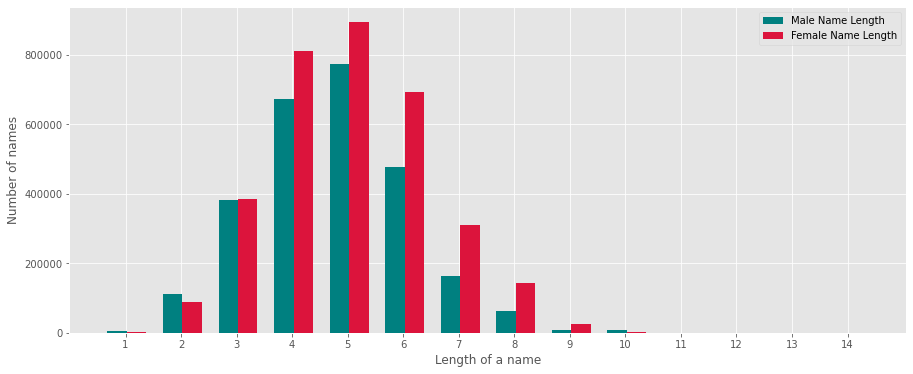

In [351]:
fig,ax = plt.subplots(figsize=[15,6])
labels = np.arange(1,15)
width=0.35
plt.bar(male_names_len.index, male_names_len.values, 
        width=width, color='teal', label='Male Name Length')
plt.bar(female_names_len.index+width, female_names_len.values,
        width=width, color='crimson', label='Female Name Length')
plt.xticks(male_names_len.index+0.15, labels)
plt.xlabel('Length of a name')
plt.ylabel('Number of names')
plt.legend()
plt.show()

**6. Last letter vowel or not**

In [362]:
males['last_letter'] = [x[-1] for x in males.name]
females['last_letter'] = [x[-1] for x in females.name]

In [375]:
vowel_m = males.loc[(males.last_letter == 'a')|
                    (males.last_letter == 'e')|
                    (males.last_letter == 'i')|
                    (males.last_letter == 'o')|
                    (males.last_letter == 'u')]

vowel_f = females.loc[(females.last_letter == 'a')|
                    (females.last_letter == 'e')|
                    (females.last_letter == 'i')|
                    (females.last_letter == 'o')|
                    (females.last_letter == 'u')]

Text(0.5, 1.0, 'Females')

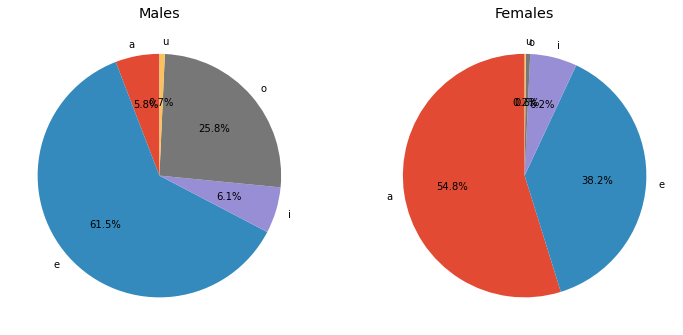

In [398]:
fig,ax = plt.subplots(1,2, figsize=[12,6])
vowels_m_count = vowel_m.last_letter.value_counts().sort_index()
vowels_f_count = vowel_f.last_letter.value_counts().sort_index()

labels = ['a','e','i','o','u']

ax[0].pie(vowels_m_count.values, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Males')
ax[1].pie(vowels_f_count.values, labels=labels, autopct='%1.1f%%', startangle=90)
ax[1].set_title('Females')

***
## Classifying names into genders
***

**Segregating the names according to the assigned gender**

In [87]:
gender_seg = pd.pivot_table(df, values='chk', index='name', columns='gender', aggfunc=np.sum)

In [88]:
gender1 = gender_seg.loc[gender_seg.F>0].index
gender1_label = gender1.shape[0]*['female']
gender1_df = pd.DataFrame({'name':gender1, 'gender':gender1_label})

gender2 = gender_seg.loc[gender_seg.M>0].index
gender2_label = gender2.shape[0]*['male']
gender2_df = pd.DataFrame({'name':gender2, 'gender':gender2_label})

In [89]:
ndf = pd.concat([gender1_df, gender2_df], axis=0)

In [215]:
ndf.head()

,name,gender,name_len,last_letter_vowel,num_vowels,num_consonents,ascii_value,class
0,aadhira,female,7,1,4,3,102.000,1
1,aadhya,female,6,1,3,3,102.667,1
2,aadya,female,5,1,3,2,102.400,1
3,aahana,female,6,1,4,2,100.333,1
4,aahna,female,5,1,3,2,101.000,1


**Creating a new feature on name length**

In [90]:
ndf['name_len'] = ndf['name'].apply(lambda x: len(x))

**Creating a new feature on last letter of the name**

In [91]:
ndf['last_letter_vowel'] = ndf['name'].apply(lambda x: 1 if x[-1] in ['a','e','i','o','u'] else 0)

**Creating a new feature for calculating the number of vowels and consonents in a name**

<font color=blue>Helper function for consonent and vowel calculation</font>

In [218]:
def letter_class(name):
    name_list = [x for x in name]
    vowel_counter = 0
    consonent_counter = 0
    for letter in name_list:
        if letter in ['a','e','i','o','u']:
            vowel_counter+=1
        else:
            consonent_counter+=1
    
    return vowel_counter, consonent_counter

In [93]:
ndf['num_vowels'] = ndf['name'].apply(lambda x: letter_class(x)[0])
ndf['num_consonents'] = ndf['name'].apply(lambda x: letter_class(x)[1])

**Quantifying value of a name in terms of average ascii value of name**

<font color=blue>Helper function for calculating average ascii value of name</font>

In [94]:
def ascii_mean(name):
    ascii_list = [ord(x) for x in name]
    return np.array(ascii_list).mean()

In [95]:
ndf['ascii_value'] = ndf['name'].apply(lambda x: ascii_mean(x).round(3))

In [223]:
def name_convertor(name_list):
    ndf = pd.DataFrame([], columns=['name','ascii_value','name_len',
                                    'num_vowels','num_consonents','last_letter_vowel', 
                                   ])
    ndf['name'] = name_list
    ndf['ascii_value'] = ndf['name'].apply(lambda x: ascii_mean(x).round(3))
    ndf['name_len'] = ndf['name'].apply(lambda x: len(x))
    ndf['last_letter_vowel'] = ndf['name'].apply(lambda x: 1 if x[-1] in ['a','e','i','o','u'] else 0)
    ndf['num_vowels'] = ndf['name'].apply(lambda x: letter_class(x)[0])
    ndf['num_consonents'] = ndf['name'].apply(lambda x: letter_class(x)[1])
    
    return ndf

**Encoding the gender as binary values**

In [96]:
ndf['class'] = ndf['gender'].apply(lambda x: 1 if x=='female' else 0)

In [104]:
dataset = ndf[['ascii_value','name_len', 'num_vowels','num_consonents','last_letter_vowel','class']]

In [105]:
dataset

,ascii_value,name_len,num_vowels,num_consonents,last_letter_vowel,class
0,102.000,7,4,3,1,1
1,102.667,6,3,3,1,1
2,102.400,5,3,2,1,1
3,100.333,6,4,2,1,1
4,101.000,5,3,2,1,1
...,...,...,...,...,...,...
13780,113.333,6,2,4,0,0
13781,113.600,10,5,5,0,0
13782,113.600,5,1,4,0,0
13783,115.600,5,1,4,0,0


### Classifying baby genders from names

In [123]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

**Creating training and testing sets**

In [168]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.3, random_state=42)

In [169]:
print('Size of training set = ', X_train.shape[0])
print('Size of testing set = ', X_test.shape[0])

Size of training set =  24245
Size of testing set =  10392


### Model 1: Logistic Regression

In [265]:
logreg = LogisticRegression(random_state=42).fit(X_train, y_train)

In [266]:
y_predict_logreg = logreg.predict(X_test)

Text(33.0, 0.5, 'Actual Genders')

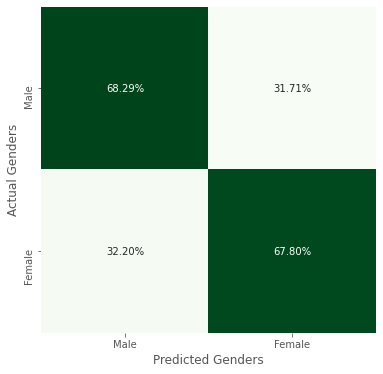

In [267]:
cf_matrix = pd.crosstab(y_test, y_predict_logreg, normalize='index')

fig = plt.subplots(figsize=[6,6])
fig = sns.heatmap(cf_matrix, 
            fmt='.2%',
            annot=True, 
            cmap='Greens',
            cbar=False)

plt.xticks([0.5, 1.5], ['Male','Female'])
plt.yticks([0.5, 1.5], ['Male','Female'])
plt.xlabel('Predicted Genders')
plt.ylabel('Actual Genders')

In [268]:
pd.DataFrame(classification_report(y_test, y_predict_logreg, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.583798,0.763731,0.679946,0.673765,0.692101
recall,0.682862,0.678018,0.679946,0.680440,0.679946
f1-score,0.629456,0.718327,0.679946,0.673891,0.682948
support,4137.000000,6255.000000,0.679946,10392.000000,10392.000000


### Model 2: Support Vector Classifier

In [269]:
svc = SVC(kernel='linear')

In [270]:
svc.fit(X_train, y_train)

SVC(kernel='linear')

In [271]:
y_predict_svc = svc.predict(X_test)

Text(33.0, 0.5, 'Actual Genders')

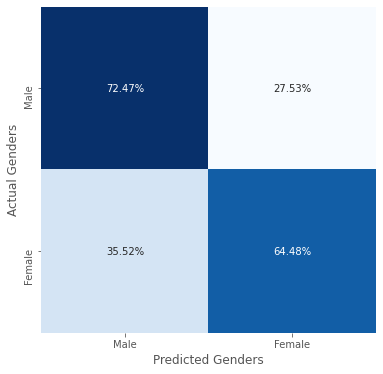

In [276]:
cf_matrix = pd.crosstab(y_test, y_predict_svc, normalize='index')

fig = plt.subplots(figsize=[6,6])
fig = sns.heatmap(cf_matrix, 
            fmt='.2%',
            annot=True, 
            cmap='Blues',
            cbar=False)

plt.xticks([0.5, 1.5], ['Male','Female'])
plt.yticks([0.5, 1.5], ['Male','Female'])
plt.xlabel('Predicted Genders')
plt.ylabel('Actual Genders')

In [277]:
pd.DataFrame(classification_report(y_test, y_predict_svc, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.574330,0.779776,0.676578,0.677053,0.697989
recall,0.724680,0.644764,0.676578,0.684722,0.676578
f1-score,0.640804,0.705872,0.676578,0.673338,0.679969
support,4137.000000,6255.000000,0.676578,10392.000000,10392.000000


# Me vs Machines

In [249]:
random_data = df.sample(n=10)
random_names = random_data.name

In [250]:
print(random_names)

99297           dan
34473        brooke
219396      antoine
139013       robert
5443      constance
90407     chriselda
58534          shea
66798       caitlin
13952      caroline
101038       dwayne
Name: name, dtype: object


In [290]:
my_guess = ['M', 'F', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M']
my_guess_class = [0, 1, 0, 0, 1, 1, 0, 1, 1, 0]

In [291]:
input_names = name_convertor(random_names)

In [293]:
log_reg_op = logreg.predict(input_names.iloc[:,1:].values)
svc_op = svc.predict(input_names.iloc[:,1:].values)

In [303]:
output = pd.DataFrame({'Names': random_names,
                       'Anirudh':my_guess_class,
                       'LogReg Prediction':log_reg_op,
                       'SVC Prediction': svc_op,
                       'Actual Gender':random_data.gender.apply(lambda x: 1 if x=='F' else 0)})

In [295]:
anirudh = pd.crosstab(output['Actual Gender'], output['Anirudh'], normalize=True)
logreg_pred = pd.crosstab(output['Actual Gender'], output['LogReg Prediction'], normalize=True)
svc_pred = pd.crosstab(output['Actual Gender'], output['SVC Prediction'], normalize=True)

In [296]:
pd.DataFrame(classification_report(output['Actual Gender'], output['Anirudh'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.800000,1.000000,0.9,0.900000,0.92000
recall,1.000000,0.833333,0.9,0.916667,0.90000
f1-score,0.888889,0.909091,0.9,0.898990,0.90101
support,4.000000,6.000000,0.9,10.000000,10.00000


In [297]:
pd.DataFrame(classification_report(output['Actual Gender'], output['LogReg Prediction'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.666667,0.714286,0.7,0.690476,0.695238
recall,0.500000,0.833333,0.7,0.666667,0.700000
f1-score,0.571429,0.769231,0.7,0.670330,0.690110
support,4.000000,6.000000,0.7,10.000000,10.000000


In [298]:
pd.DataFrame(classification_report(output['Actual Gender'], output['SVC Prediction'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.666667,0.714286,0.7,0.690476,0.695238
recall,0.500000,0.833333,0.7,0.666667,0.700000
f1-score,0.571429,0.769231,0.7,0.670330,0.690110
support,4.000000,6.000000,0.7,10.000000,10.000000


In [304]:
output['Anirudh'] = output['Anirudh'].apply(lambda x: 'F' if x==1 else 'M')
output['Actual Gender'] = output['Actual Gender'].apply(lambda x: 'F' if x==1 else 'M')
output['LogReg Prediction'] = output['LogReg Prediction'].apply(lambda x: 'F' if x==1 else 'M')
output['SVC Prediction'] = output['SVC Prediction'].apply(lambda x: 'F' if x==1 else 'M')

In [305]:
output

,Names,Anirudh,LogReg Prediction,SVC Prediction,Actual Gender
99297,dan,M,M,M,M
34473,brooke,F,F,F,F
219396,antoine,M,F,F,M
139013,robert,M,M,M,M
5443,constance,F,F,F,F
90407,chriselda,F,F,F,F
58534,shea,M,F,F,F
66798,caitlin,F,M,M,F
13952,caroline,F,F,F,F
101038,dwayne,M,F,F,M
